In [22]:
# Data Processing
import pandas as pd
import numpy as np
import re
from numpy import mean, std

# Data visualization
!pip install matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Creating the modeling dataset
from sklearn.datasets import make_classification

# Feature selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Model and performance
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     RandomizedSearchCV,
                                     cross_val_score, 
                                     KFold, 
                                     RepeatedKFold)
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, 
                             ConfusionMatrixDisplay,
                             matthews_corrcoef,
                            accuracy_score)
from sklearn.metrics import classification_report
from datetime import datetime
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Over sampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

# Treating data imbalance
!pip install -U imbalanced-learn

# checking memory space usage
import tracemalloc

# normality check
import math
from scipy.stats import shapiro #shapiro-wilk test

import warnings
warnings.filterwarnings("ignore")

## Loading and prepraing dataset

In [3]:
# Loading dataset
df1 = pd.read_csv('adult_data.csv', header = None, na_values =' ?') # Passing ' ?' as na_values
df2 = pd.read_csv('adult_test.csv', header = None, na_values =' ?') # Passing ' ?' as na_values
df = pd.concat([df1, df2], ignore_index = True)
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
                'occupation', 'relationship','race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week',
                'country', 'income']
df.columns = column_names

# Changing the target variable class from categorical to numerical
df_mod = df.copy()
df_mod['income'] = df_mod['income'].str.replace('<=50K.', '<=50K',regex=False)
df_mod['income'] = df_mod['income'].str.replace('>50K.', '>50K', regex=False)
income_map={' <=50K':0,' >50K':1}
df_mod['income']=df_mod['income'].map(income_map).astype(int)
df_mod.income.value_counts()

# Aggregating class levels of 'Education' category
df_mod['education'] = df_mod['education'].str.replace('11th','High-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('9th','High-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('7th-8th','Junior-High', regex = True)
df_mod['education'] = df_mod['education'].str.replace('5th-6th', 'Primary', regex = True)
df_mod['education'] = df_mod['education'].str.replace('10th','High-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('1st-4th','Primary', regex = True)
df_mod['education'] = df_mod['education'].str.replace('Preschool','Pre-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('12th','High-school', regex = True)
df_mod['education'] = df_mod['education'].str.replace('Bachelors','Bachelors', regex = True)
df_mod['education'] = df_mod['education'].str.replace('HS-grad','HS-grad', regex = True)
df_mod['education'] = df_mod['education'].replace(['Masters', 'Prof-school'],'Masters', regex = True)
df_mod['education'] = df_mod['education'].replace(['Some-college','Assoc-acdm', 'Assoc-voc'],'College', regex = True)
df_mod['education'] = df_mod['education'].str.replace('Doctorate','Doctorate', regex = True)
df_mod['education'].unique()

# Dropping Duplicates
df_mod = df_mod.drop_duplicates()

# Removing missing values
x = df_mod.copy()
df_m1 = x.dropna()

# Data Encoding
df_m1_num = df_m1.drop(['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'country'], axis=1)
df_encoded1 = pd.get_dummies(df_m1[['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'country']],)
df_encoded1 = pd.concat([df_encoded1, df_m1_num], axis=1)
df_encoded1

# Train-test split for df_encoded1 dataset
X = df_encoded1.drop('income', axis=1) # all independent variables execpt the target 'income'
y = df_encoded1['income'] # Target variable
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3)
print("The number of records in the training set is", X_train1.shape[0])
print("The number of records in the test set is", X_test1.shape[0])

The number of records in the training set is 31622
The number of records in the test set is 13553


## Random Forest: Baseline model

Train accuracy 0.9998735057871102
Test accuracy 0.8497011731719915
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10162
           1       0.74      0.61      0.67      3391

    accuracy                           0.85     13553
   macro avg       0.81      0.77      0.79     13553
weighted avg       0.84      0.85      0.84     13553



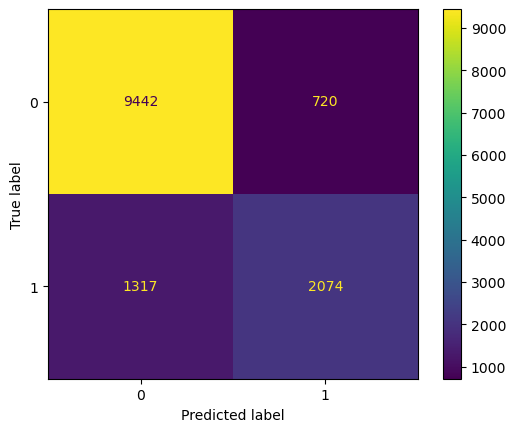

MCC score: 0.58


In [33]:
# Random Forest Classifier on df_encoded1 data

cf = RandomForestClassifier()
X_train = X_train1
X_test = X_test1
y_train = y_train1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()
# MCC score
print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

## Random Forest: Class Imbalance treated

Train accuracy 0.9999160052076771
Test accuracy 0.8443886962296171
              precision    recall  f1-score   support

           0       0.89      0.90      0.90     10162
           1       0.69      0.68      0.68      3391

    accuracy                           0.84     13553
   macro avg       0.79      0.79      0.79     13553
weighted avg       0.84      0.84      0.84     13553



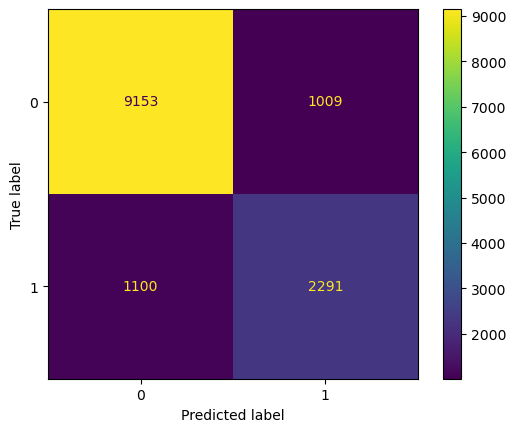

MCC score: 0.58


In [34]:
# Random Oversampling
ros = RandomOverSampler()
X_train_ros1, y_train_ros1 = ros.fit_resample(X_train1, y_train1)


# Running model
cf = RandomForestClassifier()
X_train = X_train_ros1
X_test = X_test1
y_train = y_train_ros1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

# MCC score
print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

Train accuracy 0.9999160052076771
Test accuracy 0.8482992695344205
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     10162
           1       0.72      0.64      0.68      3391

    accuracy                           0.85     13553
   macro avg       0.80      0.78      0.79     13553
weighted avg       0.84      0.85      0.84     13553



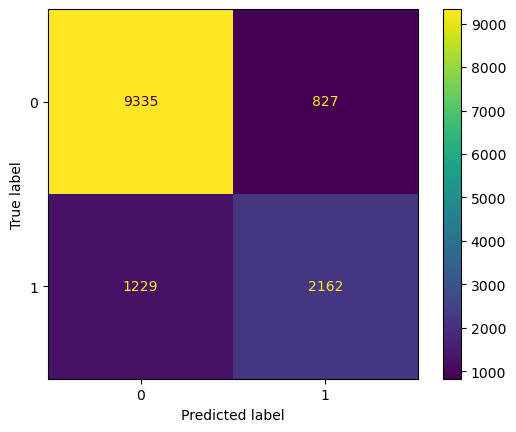

MCC score: 0.58


In [35]:
# SMOTE Oversampling
smote1 = SMOTE()
X_train_smote1, y_train_smote1 = smote1.fit_resample(X_train1, y_train1)

# Running model
cf = RandomForestClassifier()
X_train = X_train_smote1
X_test = X_test1
y_train = y_train_smote1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

# MCC score
print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

Train accuracy 1.0
Test accuracy 0.8079392016527706
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     10162
           1       0.58      0.83      0.68      3391

    accuracy                           0.81     13553
   macro avg       0.76      0.81      0.77     13553
weighted avg       0.85      0.81      0.82     13553



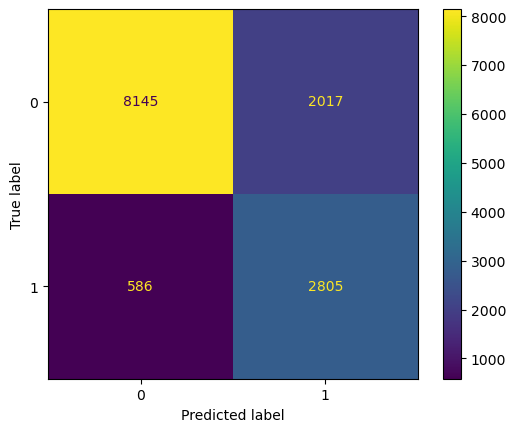

MCC score: 0.57


In [36]:
# Random Undersampling
rus1 = RandomUnderSampler()
X_train_rus1, y_train_rus1 = rus1.fit_resample(X_train1, y_train1)

# Running model
cf = RandomForestClassifier()
X_train = X_train_rus1
X_test = X_test1
y_train = y_train_rus1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

# MCC score
print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

Train accuracy 0.9999359877096402
Test accuracy 0.8144322290267837
              precision    recall  f1-score   support

           0       0.93      0.81      0.87     10162
           1       0.59      0.81      0.69      3391

    accuracy                           0.81     13553
   macro avg       0.76      0.81      0.78     13553
weighted avg       0.85      0.81      0.82     13553



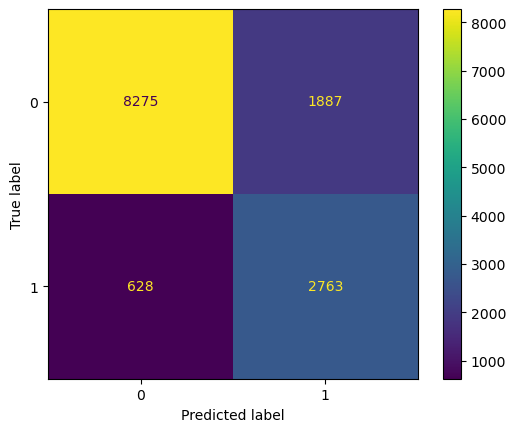

MCC score: 0.57


In [37]:
# NearMiss Undersampling
nearmiss1 = NearMiss(version=3)
X_train_nearmiss1, y_train_nearmiss1 = nearmiss1.fit_resample(X_train1, y_train1)

cf = RandomForestClassifier()
X_train = X_train_nearmiss1
X_test = X_test1
y_train = y_train_nearmiss1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

# MCC score
print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

## Random Forest: Hyper-parameter tuning

### Building hyperparameters

In [9]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 80, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,4]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

### Creating dictionary with parameters

In [10]:
params = {'n_estimators': n_estimators,
          'max_features': max_features,
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf,
          'bootstrap': bootstrap}
print(params)

{'n_estimators': [10, 17, 25, 33, 41, 48, 56, 64, 72, 80], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 4], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


### Timer setup

In [11]:
# Creating a timer to check time-lapse
# from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

### Tuning with GridSearchCV

In [12]:
from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = cf, param_grid = params, cv = 10, verbose=2, n_jobs = 4) # cf=RandomForestClassifier() alrready defined

In [13]:
#Tuning on the base dataset
start_time = timer(None) # timing starts from this point for "start_time" variable
rf_Grid.fit(X_train1, y_train1)
timer(start_time) # timing ends here for "start_time" variable

Fitting 10 folds for each of 320 candidates, totalling 3200 fits
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=17; total time=   0.1s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.2s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=25; total time=   0.

Total time taken: 0 hours 6 minutes and 45.83 seconds.

In [14]:
rf_Grid.best_params_

{'bootstrap': False,
 'max_depth': 4,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 72}

### Tuning with RandomizedSearchCV

In [15]:
# from sklearn.model_selection import RandomizedSearchCV
rf_RandomGrid = RandomizedSearchCV(estimator = cf, 
                                   param_distributions = params, 
                                   cv = 10, verbose=2, n_jobs = 4) # cf=RandomForestClassifier() alrready defined

In [16]:
#Tuning on the base dataset
start_time = timer(None) # timing starts from this point for "start_time" variable
rf_RandomGrid.fit(X_train1, y_train1)
timer(start_time) # timing ends here for "start_time" variable

Fitting 10 folds for each of 10 candidates, totalling 100 fits

 Time taken: 0 hours 0 minutes and 14.0 seconds.


Total time taken: 0 hours 0 minutes and 11.46 seconds.

In [17]:
rf_RandomGrid.best_params_

{'n_estimators': 80,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 4,
 'bootstrap': False}

### Checking Accuracy on base data

In [18]:
# GridSearchCV
print (f'Train Accuracy - : {rf_Grid.score(X_train1,y_train1):.2f}')
print (f'Test Accuracy - : {rf_Grid.score(X_test1,y_test1):.2f}')

Train Accuracy - : 0.82
Test Accuracy - : 0.82


In [19]:
# RandomizedSearchCV
print (f'Train Accuracy - : {rf_RandomGrid.score(X_train1,y_train1):.2f}')
print (f'Test Accuracy - : {rf_RandomGrid.score(X_test1,y_test1):.2f}')

Train Accuracy - : 0.82
Test Accuracy - : 0.82


RandomizedSearchCV shows less time and higher accuracy. As a result, we will use the 'best params' from randimized search on our oversampled and undersamples data and for cross validation

## Random Forest: Hyper-parameter tuning on oversampled / undersampled data

In [20]:
cf = RandomForestClassifier(bootstrap= False, 
                            max_depth= 4, 
                            max_features='sqrt', 
                            min_samples_leaf=2, 
                            min_samples_split=2,
                            n_estimators=72)

Train accuracy 0.7808365881315359
Test accuracy 0.7365159005386261
              precision    recall  f1-score   support

           0       0.94      0.69      0.80     10162
           1       0.49      0.87      0.62      3391

    accuracy                           0.74     13553
   macro avg       0.71      0.78      0.71     13553
weighted avg       0.83      0.74      0.75     13553



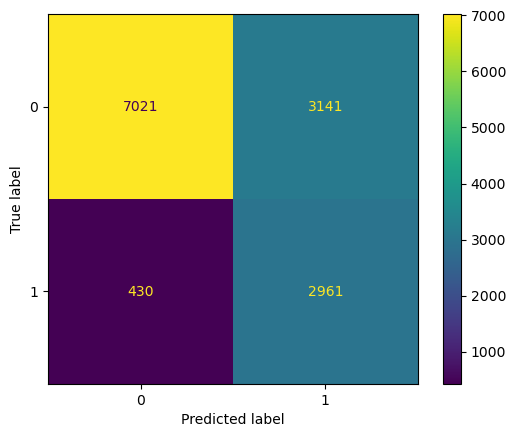

MCC score: 0.49


In [24]:
# Random oversampled data
ros = RandomOverSampler()
X_train_ros1, y_train_ros1 = ros.fit_resample(X_train1, y_train1)


# Running model
cf = RandomForestClassifier(bootstrap= False, 
                            max_depth= 4, 
                            max_features='auto', 
                            min_samples_leaf=2, 
                            min_samples_split=5,
                            n_estimators=20)
X_train = X_train_ros1
X_test = X_test1
y_train = y_train_ros1
y_test = y_test1



model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

# MCC score
print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

Train accuracy 0.8455755743143925
Test accuracy 0.780565188519147
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     10162
           1       0.54      0.80      0.65      3391

    accuracy                           0.78     13553
   macro avg       0.73      0.79      0.74     13553
weighted avg       0.83      0.78      0.79     13553



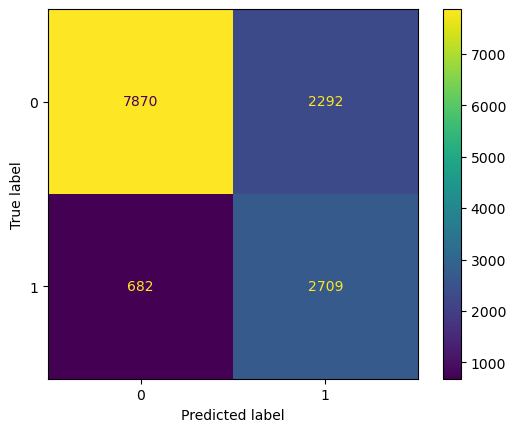

MCC score: 0.51


In [25]:
# SMOTE oversampled data
smote1 = SMOTE()
X_train_smote1, y_train_smote1 = smote1.fit_resample(X_train1, y_train1)

# Running model
cf = RandomForestClassifier(bootstrap= False, 
                            max_depth= 4, 
                            max_features='sqrt', 
                            min_samples_leaf=2, 
                            min_samples_split=2,
                            n_estimators=72)
X_train = X_train_smote1
X_test = X_test1
y_train = y_train_smote1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

# MCC score
print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

Train accuracy 0.7853667904237613
Test accuracy 0.7461816571976684
              precision    recall  f1-score   support

           0       0.94      0.70      0.81     10162
           1       0.50      0.87      0.63      3391

    accuracy                           0.75     13553
   macro avg       0.72      0.79      0.72     13553
weighted avg       0.83      0.75      0.76     13553



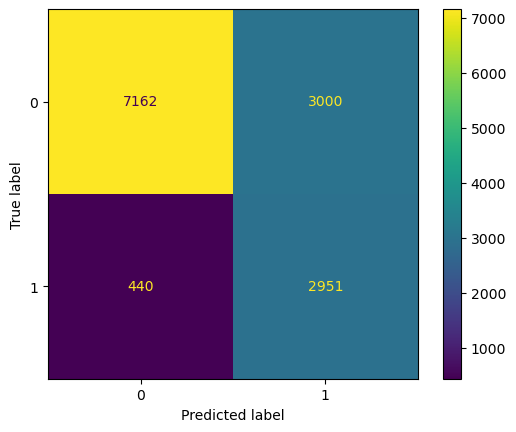

MCC score: 0.50


In [26]:
# Random undersampled data
rus1 = RandomUnderSampler()
X_train_rus1, y_train_rus1 = rus1.fit_resample(X_train1, y_train1)

# Running model
cf = RandomForestClassifier(bootstrap= False, 
                            max_depth= 4, 
                            max_features='sqrt', 
                            min_samples_leaf=2, 
                            min_samples_split=2,
                            n_estimators=72)
X_train = X_train_rus1
X_test = X_test1
y_train = y_train_rus1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

# MCC score
print(f'MCC score: {matthews_corrcoef(y_test, y_pred):.2f}')

Train accuracy 0.7703879144795801
Test accuracy 0.7503873681103814
              precision    recall  f1-score   support

           0       0.94      0.71      0.81     10162
           1       0.50      0.86      0.63      3391

    accuracy                           0.75     13553
   macro avg       0.72      0.79      0.72     13553
weighted avg       0.83      0.75      0.77     13553



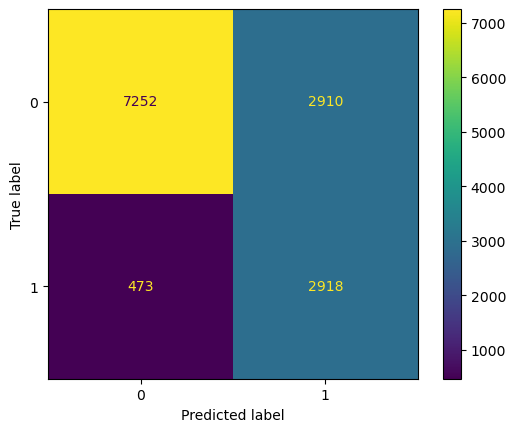

MCC score 0.5023096082180415


In [27]:
# NearMiss undersampling
nearmiss1 = NearMiss(version=3)
X_train_nearmiss1, y_train_nearmiss1 = nearmiss1.fit_resample(X_train1, y_train1)

cf = RandomForestClassifier(bootstrap= False, 
                            max_depth= 4, 
                            max_features='sqrt', 
                            min_samples_leaf=2, 
                            min_samples_split=2,
                            n_estimators=72)
X_train = X_train_nearmiss1
X_test = X_test1
y_train = y_train_nearmiss1
y_test = y_test1

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


# Check the model performance
print('Train accuracy', accuracy_score(y_train, y_train_pred))
print('Test accuracy', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

# MCC score
print ('MCC score', matthews_corrcoef(y_test, y_pred))

In [28]:
# memory space usage tracking
# import tracemalloc 
def app():
    lt = []
    for i in range(0, 100000):
        lt.append(i)

### K-Fold Cross Validation

In [32]:
# from sklearn.model_selection import cross_val_score
# K-Fold Cross validation on base dataset

cf = RandomForestClassifier()

# starting timer
start_time = timer(None)

# starting the memory monitoring
tracemalloc.start()

# function call
app()

# running cross-val
kfold_score = cross_val_score (cf, X_train1, y_train1, scoring='accuracy', cv=5)

# time stopper
timer(start_time)

# displaying the memory (current, peak)
print('memory usage: Current, Peak', tracemalloc.get_traced_memory())
 
# stopping the memorylibrary
tracemalloc.stop()

print(kfold_score)
print(np.average(kfold_score))


 Time taken: 0 hours 0 minutes and 16.33 seconds.
memory usage: Current, Peak (51072, 35301965)
[0.84806324 0.8512253  0.85388994 0.84677419 0.84677419]
0.849345373544037


### Repeated K-Fold Cross Validation

In [47]:
# Repeated K-Fold on base dataset

cv1 = RepeatedKFold(n_splits=10, n_repeats=5)
cf = RandomForestClassifier()

# starting timer
start_time = timer(None)

# starting the memory monitoring
tracemalloc.start()

# function call
app()
 
# running cross-val
repeatK_scores = cross_val_score(cf, X_train1, y_train1, scoring='accuracy', cv=cv1)

# time stopper
timer(start_time)

# displaying the memory (current, peak)
print('memory usage: Current, Peak', tracemalloc.get_traced_memory())
 
# stopping the memorylibrary
tracemalloc.stop()

print (repeatK_scores)
print('Accuracy: %.3f (%.3f)' % (mean(repeatK_scores), std(repeatK_scores)))


 Time taken: 0 hours 3 minutes and 2.95 seconds.
memory usage: Current, Peak (108082, 39238576)
[0.86120771 0.84476763 0.84756483 0.86116382 0.8456673  0.85895003
 0.85262492 0.84187223 0.85262492 0.84724858 0.84571609 0.85678154
 0.85294118 0.84882985 0.84693232 0.84819734 0.8456673  0.85483871
 0.85009488 0.84724858 0.84950996 0.84887765 0.84693232 0.85673624
 0.85199241 0.83965844 0.84693232 0.85294118 0.85768501 0.85325743
 0.84698071 0.8548846  0.84629981 0.84788109 0.8570525  0.8485136
 0.85167615 0.86622391 0.84345351 0.84914611 0.8605754  0.85267151
 0.84535104 0.85388994 0.85515497 0.85357369 0.84629981 0.84598355
 0.8542062  0.84661607]
Accuracy: 0.851 (0.005)


### Checking the distribution of the repeated K-Fold scores

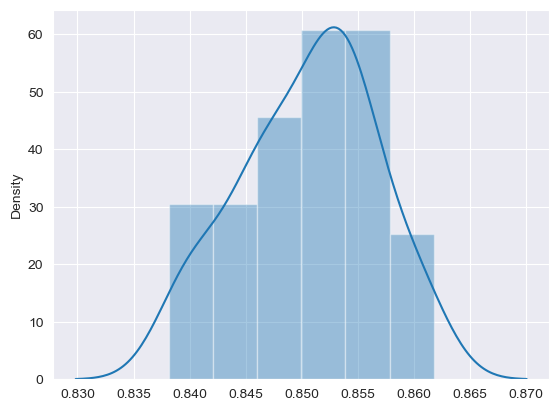

In [39]:
sns.set_style('darkgrid')
sns.distplot(repeatK_scores);

### Normality check through Shapiro-Wilk Test

In [40]:
# normality check for the repeatK_scores

shapiro(repeatK_scores)

ShapiroResult(statistic=0.9749565124511719, pvalue=0.3635585606098175)

From the output, we can see that p-value is greater than 0.05 which means that we have sufficient evidence to accept the null hypothesis which is the data is normally distributed

## Variance check

### Creating dataframe of the Repeated K-Fold scores of the model for variance check with other models

In [45]:
score_list = repeatK_scores.T
df = pd.DataFrame(score_list, columns = ['RF'])
df
df.to_csv('Repeated K-Fold Cross Validation Scores.csv', index=False)

In [46]:
df.head()

,RF
0,0.853936
1,0.854885
2,0.841240
3,0.853574
4,0.860848


## Categorical Feature Selection 

2 popular feature selection techniques for categorical data are:
* **Chi-Squared Statistic**
* **Mutual Informaion Statistic**

### Chi-Squared Statistic

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     10237
           1       0.78      0.60      0.68      3316

    accuracy                           0.86     13553
   macro avg       0.83      0.78      0.80     13553
weighted avg       0.86      0.86      0.86     13553



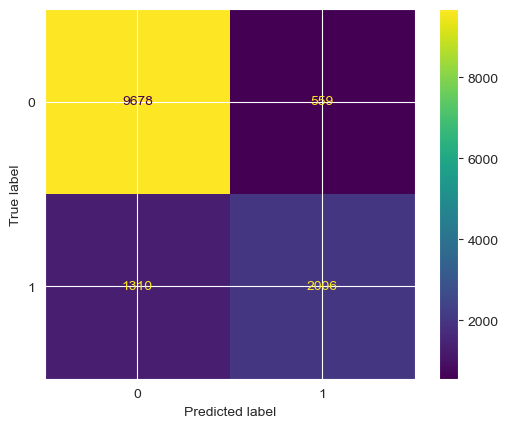

MCC score 0.6039786461375495


In [43]:
df = df_encoded1.copy()
X = df.drop('income', axis=1) # all independent variables execpt the target income
y = df['income'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Feature Selection

fs = SelectKBest(score_func=chi2, k=70) # keeping all the features
fs.fit(X_train, y_train)
X_train_fs = fs.transform(X_train)
X_test_fs = fs.transform(X_test)

# running the model
cf = RandomForestClassifier(n_estimators=30, max_depth= 25, min_samples_leaf=3 )
X_train = X_train_fs
X_test = X_test_fs
y_train = y_train
y_test = y_test

model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)


# Check the model performance
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

# MCC score
print ('MCC score', matthews_corrcoef(y_test, y_pred))

### Mutual Information Feature Selection

              precision    recall  f1-score   support

           0       0.88      0.94      0.91     10171
           1       0.78      0.60      0.68      3382

    accuracy                           0.86     13553
   macro avg       0.83      0.77      0.79     13553
weighted avg       0.85      0.86      0.85     13553



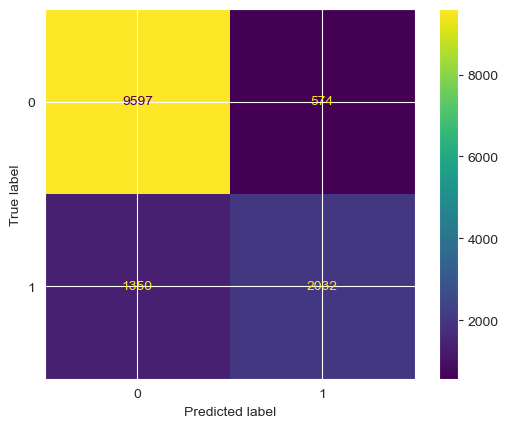

MCC score 0.5977868491791852


In [44]:
df = df_encoded1.copy()
X = df.drop('income', axis=1) # all independent variables execpt the target income
y = df['income'] # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Feature Selection

fs = SelectKBest(score_func=mutual_info_classif, k='all') # keeping all the features
fs.fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

# running the model
cf = RandomForestClassifier(n_estimators=30, max_depth= 25, min_samples_leaf=3 )
model = cf.fit(X_train, y_train)
y_pred = model.predict(X_test)


# Check the model performance
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format = '') # values_format to suppress scientific notation
plt.show()

# MCC score
print ('MCC score', matthews_corrcoef(y_test, y_pred))